RNN (Recurrent Neural Network)


ex) Teache 이 글자가 흐트러져있을 경우, 그 다음에 들어갈 알파벳이 뭔지? 알기 위해서 쓰는 시퀀스 모델은 RNN이다. RNN은 이러한 작업을 잘 해.


더 긴문장을 잘 알기 위해서 사용한게 LSTM입니다.
그래서 RNN은 잘 안씀. 우리는 RNN을 통해서 주가를 알아보는 작업을 할 거야.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
raw_data = pd.read_csv('./datasets/samsung202401.csv')
print(raw_data.head())
raw_data.info()

         Date    Open    High     Low   Close    Adj Close    Volume
0  2000-01-04  6000.0  6110.0  5660.0  6110.0  4514.580078  74195000
1  2000-01-05  5800.0  6060.0  5520.0  5580.0  4122.972168  74680000
2  2000-01-06  5750.0  5780.0  5580.0  5620.0  4152.526855  54390000
3  2000-01-07  5560.0  5670.0  5360.0  5540.0  4093.415283  40305000
4  2000-01-10  5600.0  5770.0  5580.0  5770.0  4263.360840  46880000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6033 entries, 0 to 6032
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6033 non-null   object 
 1   Open       6033 non-null   float64
 2   High       6033 non-null   float64
 3   Low        6033 non-null   float64
 4   Close      6033 non-null   float64
 5   Adj Close  6033 non-null   float64
 6   Volume     6033 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 330.1+ KB


In [27]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6033 entries, 0 to 6032
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6033 non-null   datetime64[ns]
 1   Open       6033 non-null   float64       
 2   High       6033 non-null   float64       
 3   Low        6033 non-null   float64       
 4   Close      6033 non-null   float64       
 5   Adj Close  6033 non-null   float64       
 6   Volume     6033 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 330.1 KB


In [28]:
raw_data.set_index('Date',inplace=True)
print(raw_data.head())

              Open    High     Low   Close    Adj Close    Volume
Date                                                             
2000-01-04  6000.0  6110.0  5660.0  6110.0  4514.580078  74195000
2000-01-05  5800.0  6060.0  5520.0  5580.0  4122.972168  74680000
2000-01-06  5750.0  5780.0  5580.0  5620.0  4152.526855  54390000
2000-01-07  5560.0  5670.0  5360.0  5540.0  4093.415283  40305000
2000-01-10  5600.0  5770.0  5580.0  5770.0  4263.360840  46880000


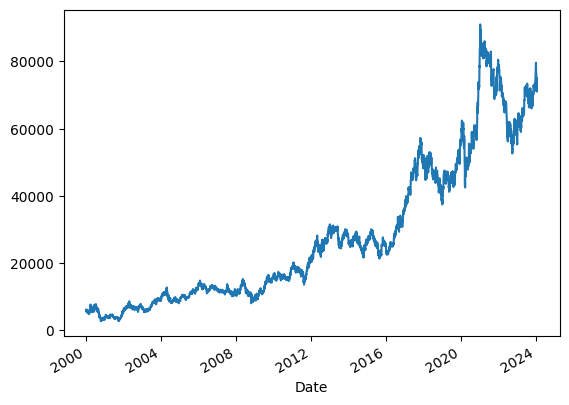

In [29]:
raw_data['Close'].plot()
plt.show()

In [30]:
data_test = raw_data.sort_values('Close')
print(data_test.head())
print(data_test.tail())
# 정가를 기준으로 sorting한 것이에요.

              Open    High     Low   Close    Adj Close     Volume
Date                                                              
2000-10-18  2540.0  2760.0  2420.0  2730.0  2017.153198  164215000
2000-10-17  2980.0  3080.0  2730.0  2740.0  2024.541260   65300000
2000-10-30  2800.0  2880.0  2720.0  2750.0  2031.931030   36830000
2001-10-03  2810.0  2810.0  2810.0  2810.0  2076.263428          0
2001-10-02  2810.0  2810.0  2810.0  2810.0  2076.263428          0
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2021-01-25  87000.0  89900.0  86300.0  89400.0  84769.585938  27258534
2021-01-13  89800.0  91200.0  89100.0  89700.0  85054.031250  36068848
2021-01-14  88700.0  90000.0  88700.0  89700.0  85054.031250  26393970
2021-01-12  90300.0  91400.0  87800.0  90600.0  85907.414063  48682416
2021-01-11  90000.0  96800.0  89500.0  91000.0  86286.710938  90306177


In [31]:
data_close = raw_data[['Close']]
print(data_close.head())

             Close
Date              
2000-01-04  6110.0
2000-01-05  5580.0
2000-01-06  5620.0
2000-01-07  5540.0
2000-01-10  5770.0


In [32]:
# 값이 크니까 스케일링을 해야해.

minmaxscaler=MinMaxScaler()
scaled_data = minmaxscaler.fit_transform(data_close)
print(scaled_data[:5]) # 리스트 안에서 5개만 보겠다.
print(scaled_data.shape) # 주식 시장이 열린 시간이 6033일이 있었음.


[[0.03829161]
 [0.0322873 ]
 [0.03274046]
 [0.03183415]
 [0.03443979]]
(6033, 1)


30개씩 묶어서 데이터를 계산하겠다는 의미.

6033개라면 30개를 잘라서 6003개만을 남김.

In [33]:
# 시퀀스 데이터 생성
sequence_X = []
sequence_Y = []
# 스케일링된 데이터에서 30일치의 시퀀스로 X, 다음날의 값으로 Y를 만듦
for i in range(len(scaled_data)-30):
  #주어진 코드에서는 for 루프를 통해 6033개의 데이터에서 30개씩 묶어서 시퀀스를 생성하고 있습니다.
  #구체적으로 말하면, i가 0부터 6002까지 반복되며
  # 각 반복에서 x에는 30일치의 데이터가, y에는 그 다음날의 데이터가 할당되고 있습니다.
  x = scaled_data[i:i+30]
  y= scaled_data[i+30]
  sequence_X.append(x)
  sequence_Y.append(y)
# 생성된 시퀀스 데이터의 일부 출력
print(sequence_X[:5])
print(sequence_Y[:5])

#이렇게 생성된 sequence_X와 sequence_Y는 각각 30일치의 시퀀스와 해당 시퀀스 다음날의 값을 담고 있습니다.
# 이러한 시퀀스 데이터를 통해 RNN 모델을 학습할 수 있습니다.

# "시퀀스"는 일련의 데이터 포인트가 특정 순서로 배열된 데이터의 집합을 나타냅니다.
#시계열 데이터의 경우, 시간에 따라 나열된 값들이 시퀀스를 형성합니다.
#예를 들어, 주식 가격 데이터에서 각 날짜에 따른 종가들이 시퀀스를 형성합니다.

[array([[0.03829161],
       [0.0322873 ],
       [0.03274046],
       [0.03183415],
       [0.03443979],
       [0.03443979],
       [0.03387334],
       [0.03376005],
       [0.03511952],
       [0.03817832],
       [0.03817832],
       [0.03659227],
       [0.03749858],
       [0.03568596],
       [0.03364677],
       [0.03070126],
       [0.03115441],
       [0.03160757],
       [0.03500623],
       [0.0322873 ],
       [0.02934179],
       [0.02854877],
       [0.02718931],
       [0.02718931],
       [0.02843548],
       [0.03058797],
       [0.03387334],
       [0.0343265 ],
       [0.03364677],
       [0.03002152]]), array([[0.0322873 ],
       [0.03274046],
       [0.03183415],
       [0.03443979],
       [0.03443979],
       [0.03387334],
       [0.03376005],
       [0.03511952],
       [0.03817832],
       [0.03817832],
       [0.03659227],
       [0.03749858],
       [0.03568596],
       [0.03364677],
       [0.03070126],
       [0.03115441],
       [0.03160757],
       [0.

In [34]:
# 시퀀스 데이터를 NumPy 배열로 변환
sequence_X = np.array(sequence_X)
sequence_Y = np.array(sequence_Y)
# 첫 번째 시퀀스 데이터와 레이블 출력
print(sequence_X[0])
print(sequence_Y[0])
# 생성된 시퀀스 데이터의 형태 출력
print(sequence_X.shape)
print(sequence_Y.shape)


[[0.03829161]
 [0.0322873 ]
 [0.03274046]
 [0.03183415]
 [0.03443979]
 [0.03443979]
 [0.03387334]
 [0.03376005]
 [0.03511952]
 [0.03817832]
 [0.03817832]
 [0.03659227]
 [0.03749858]
 [0.03568596]
 [0.03364677]
 [0.03070126]
 [0.03115441]
 [0.03160757]
 [0.03500623]
 [0.0322873 ]
 [0.02934179]
 [0.02854877]
 [0.02718931]
 [0.02718931]
 [0.02843548]
 [0.03058797]
 [0.03387334]
 [0.0343265 ]
 [0.03364677]
 [0.03002152]]
[0.02798233]
(6003, 30, 1)
(6003, 1)


주어진 코드에서는 주식 시장 데이터(data_close)를 스케일링하고, 그 스케일링된 데이터를 이용하여 30일치의 시퀀스를 만들어내고 있습니다. sequence_X는 입력 데이터 시퀀스이며, sequence_Y는 각 시퀀스 다음의 값을 나타내는 레이블입니다. 이렇게 생성된 데이터는 RNN 모델의 학습에 사용될 수 있습니다.

따라서 "여기서 6033개라면 30개를 묶어서 데이터를 계산하겠다"는 의미가 맞습니다. 각각의 시퀀스는 30일치의 데이터로 구성되어 있으며, 이를 사용하여 모델이 다음날의 값을 예측하도록 학습됩니다.

In [35]:
x_train,x_test,y_train,y_test = train_test_split( sequence_X,sequence_Y,test_size=0.2)
print(x_train.shape,y_train.shape)
print(x_train.shape, y_test.shape)

(4802, 30, 1) (4802, 1)
(4802, 30, 1) (1201, 1)


이제 모델을 만들겠습니다.

회귀 모델에서는 activation 이나 시그모이드를 안 써준다. 단일 분류기에서는 시그모이드,다중분류기일때는 소프트맥스.   
분류기와 예측기는 마지막의 출력층만 달라진다

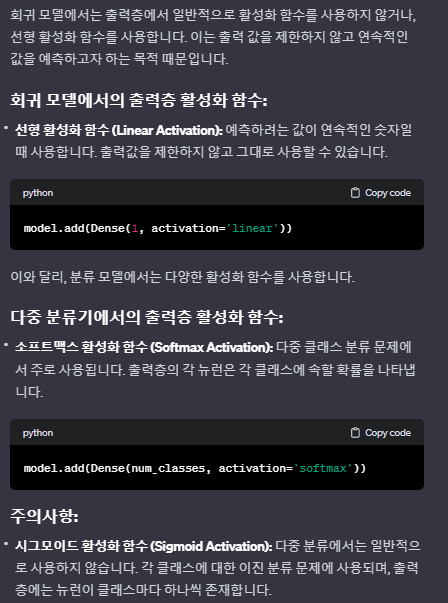


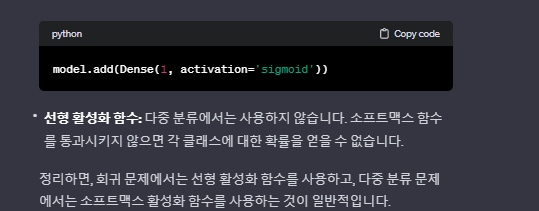

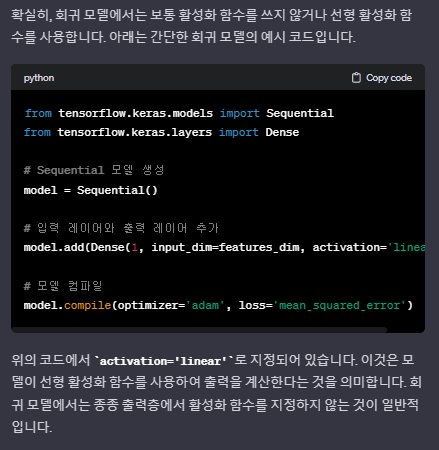

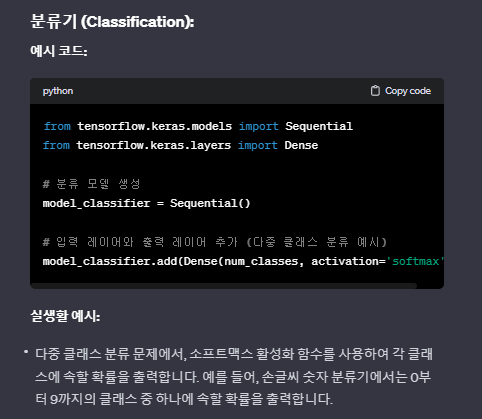

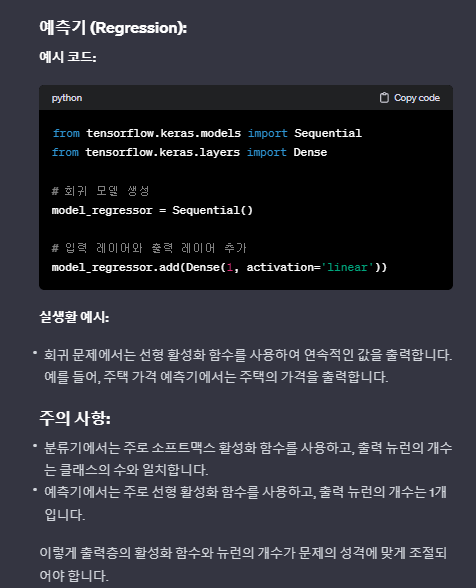

In [36]:
model = Sequential()
model.add(LSTM(50,input_shape=(30,1),activation='tanh'))
#LSTM 레이어:

#LSTM(50, input_shape=(30, 1), activation='tanh'): LSTM 레이어를 추가합니다.
#50개의 유닛(뉴런)을 사용합니다.
#input_shape=(30, 1): 입력 데이터의 형태를 지정합니다. 여기서 30은 시간 단계(time steps)의 수이고, 1은 각 시간 단계에서의 특성(feature)의 수를 나타냅니다.
#activation='tanh': 하이퍼볼릭 탄젠트(tanh) 활성화 함수를 사용합니다.
model.add(Flatten())
#  LSTM 레이어의 출력을 평탄화(flatten)합니다. 이는 2D 텐서를 1D로 변환합니다.
model.add(Dense(1))
# 하나의 뉴런을 가진 완전 연결(Dense) 레이어를 추가합니다. 회귀 문제를 다루기 위한 출력 레이어입니다.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


RNN에서 확장된 단계는 LSTM 입니다.

In [37]:
model.compile(loss='mse',optimizer='adam')
fit_hist = model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test),shuffle=False) # validation_data를 split이 아니라 바로 줘버림. validation_data 이거는 검증셋.
# 예시) 문제집을 주긴 하는 데 어떤 문제를 맞았는지 틀렸는지는 알수 없어. 점수만 알려줌.
# 데이터는 줬지만 학습을 했는지는 알 수가 없어. 저번에는 복원 추출로 결국 전부다 학습하게 만들긴 함.

Epoch 1/100
151/151 [==============================] - 5s 18ms/step - loss: 0.0151 - val_loss: 3.7368e-04
Epoch 2/100
151/151 [==============================] - 2s 15ms/step - loss: 2.8328e-04 - val_loss: 3.2450e-04
Epoch 3/100
151/151 [==============================] - 2s 14ms/step - loss: 2.6615e-04 - val_loss: 2.7193e-04
Epoch 4/100
151/151 [==============================] - 2s 15ms/step - loss: 2.5011e-04 - val_loss: 2.4791e-04
Epoch 5/100
151/151 [==============================] - 3s 23ms/step - loss: 2.3513e-04 - val_loss: 2.3764e-04
Epoch 6/100
151/151 [==============================] - 2s 15ms/step - loss: 2.1905e-04 - val_loss: 2.3976e-04
Epoch 7/100
151/151 [==============================] - 2s 15ms/step - loss: 2.0467e-04 - val_loss: 2.4315e-04
Epoch 8/100
151/151 [==============================] - 2s 15ms/step - loss: 1.9292e-04 - val_loss: 2.4179e-04
Epoch 9/100
151/151 [==============================] - 3s 21ms/step - loss: 1.8307e-04 - val_loss: 2.3675e-04
Epoch 10/100
1

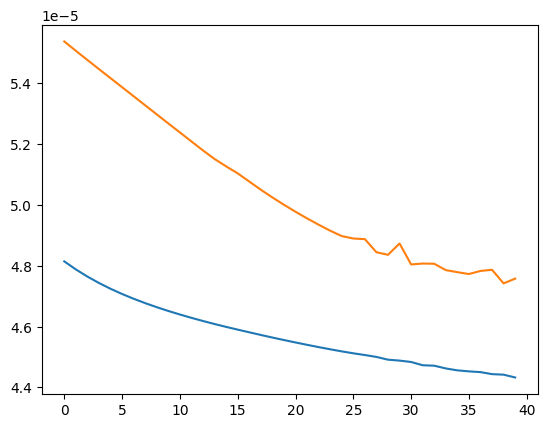

In [38]:
plt.plot(fit_hist.history['loss'][60:],label='loss')
plt.plot(fit_hist.history['val_loss'][60:],label='val loss')
plt.show()

In [38]:
score=model.evaluate(x_test,y_test,verbose=0)
print(score[0])

In [45]:
pred = model.predict(x_test)

38/38 [==============================] - 0s 10ms/step


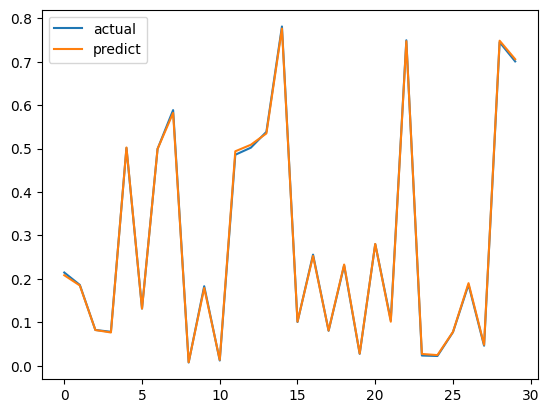

In [46]:
plt.plot(y_test[:30], label='actual')
plt.plot(pred[:30], label='predict')
plt.legend()
plt.show()

In [47]:
last_data_30 = scaled_data[-30:].reshape(1,30,1)
today_close = model.predict(last_data_30)
print(today_close)

1/1 [==============================] - 0s 22ms/step
[[0.8188893]]


In [48]:
today_close_won = minmaxscaler.inverse_transform(today_close)
print('%d 원'%today_close_won[0][0])

75013 원


---> 여기까지는 종가(?)를 가지고 예측함.